# Plot of rhodamine concentration profile evolution

Welcome to this notebook ! The code below has been developed to analyse the confocal images obtained during the freezing of emulsions. The results have been reported in the following paper:
"5D imaging of freezing emulsions with solute effects", by Dmytro Dedovets, Cécile Monteux, and Sylvain Deville, and published in Science in 2018.

If you want to use this code and the data we provided, you should organise your files as follows. Create a main directory with 2 subdirectory:
- "code": put the notebooks here
- "data": put the data here

This notebook reads two sequences of confocal images: one with the ice and water+rhodamine, and another one with the object (droplet+surfactant). The intensity profile is used to measure the concentration of rhodamine and its evolution.

The concentration ahead and behind the oil droplet in measured, as well as the thickness of the 
liquid film ahead of the oil droplet.


Feedback is welcome, keep in touch with us if you want to discuss anything,

In [1]:
#!/usr/bin/python
# -*- coding: utf-8 -*-
from __future__ import division, unicode_literals, print_function  # for compatibility with Python 2 and 3

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# change the following to %matplotlib notebook for interactive plotting
%matplotlib inline

import numpy as np
import pandas as pd
from pandas import DataFrame, Series  # for convenience
import os
import pims
import trackpy as tp
import time
import skimage as sk
from IPython import display
from IPython.display import clear_output
import ipywidgets as widgets

In [2]:
from IPython.display import display

## Constants and calibration (space and time)

In [3]:
#spf = 5.162 # seconds per frame
#mpf = 1/1.7617 # microns per frame


#for 16.075A
spf = 2.943 # seconds per frame
mpf = 775/1024 # microns per pixels

# 1.7617 pixel per microns

## Load the data (tiff stack)

In [3]:
data = pims.TiffStack('../data/DD16.075A(1mkm-sec)_2-Series007-3-solute.tif')
data_particle = pims.TiffStack('../data/DD16.075A(1mkm-sec)_2-Series007-3-particle-filtered.tif')

#data = pims.TiffStack('../data/DD17017C(5C-mm2mkm-sec3D).tif')
#data_particle = pims.TiffStack('../data/DD17017C(5C-mm2mkm-sec3D)particle.tif')

## Function to detect the peaks the intensity profile

In [6]:
# %load functions/detect_peaks.py
"""Detect peaks in data based on their amplitude and other features."""

from __future__ import division, print_function
import numpy as np

__author__ = "Marcos Duarte, https://github.com/demotu/BMC"
__version__ = "1.0.4"
__license__ = "MIT"


def detect_peaks(x, mph=None, mpd=1, threshold=0, edge='rising',
                 kpsh=False, valley=False, show=False, ax=None):

    """Detect peaks in data based on their amplitude and other features.

    Parameters
    ----------
    x : 1D array_like
        data.
    mph : {None, number}, optional (default = None)
        detect peaks that are greater than minimum peak height.
    mpd : positive integer, optional (default = 1)
        detect peaks that are at least separated by minimum peak distance (in
        number of data).
    threshold : positive number, optional (default = 0)
        detect peaks (valleys) that are greater (smaller) than `threshold`
        in relation to their immediate neighbors.
    edge : {None, 'rising', 'falling', 'both'}, optional (default = 'rising')
        for a flat peak, keep only the rising edge ('rising'), only the
        falling edge ('falling'), both edges ('both'), or don't detect a
        flat peak (None).
    kpsh : bool, optional (default = False)
        keep peaks with same height even if they are closer than `mpd`.
    valley : bool, optional (default = False)
        if True (1), detect valleys (local minima) instead of peaks.
    show : bool, optional (default = False)
        if True (1), plot data in matplotlib figure.
    ax : a matplotlib.axes.Axes instance, optional (default = None).

    Returns
    -------
    ind : 1D array_like
        indeces of the peaks in `x`.

    Notes
    -----
    The detection of valleys instead of peaks is performed internally by simply
    negating the data: `ind_valleys = detect_peaks(-x)`
    
    The function can handle NaN's 

    See this IPython Notebook [1]_.

    References
    ----------
    .. [1] http://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/DetectPeaks.ipynb

    Examples
    --------
    >>> from detect_peaks import detect_peaks
    >>> x = np.random.randn(100)
    >>> x[60:81] = np.nan
    >>> # detect all peaks and plot data
    >>> ind = detect_peaks(x, show=True)
    >>> print(ind)

    >>> x = np.sin(2*np.pi*5*np.linspace(0, 1, 200)) + np.random.randn(200)/5
    >>> # set minimum peak height = 0 and minimum peak distance = 20
    >>> detect_peaks(x, mph=0, mpd=20, show=True)

    >>> x = [0, 1, 0, 2, 0, 3, 0, 2, 0, 1, 0]
    >>> # set minimum peak distance = 2
    >>> detect_peaks(x, mpd=2, show=True)

    >>> x = np.sin(2*np.pi*5*np.linspace(0, 1, 200)) + np.random.randn(200)/5
    >>> # detection of valleys instead of peaks
    >>> detect_peaks(x, mph=0, mpd=20, valley=True, show=True)

    >>> x = [0, 1, 1, 0, 1, 1, 0]
    >>> # detect both edges
    >>> detect_peaks(x, edge='both', show=True)

    >>> x = [-2, 1, -2, 2, 1, 1, 3, 0]
    >>> # set threshold = 2
    >>> detect_peaks(x, threshold = 2, show=True)
    """

    x = np.atleast_1d(x).astype('float64')
    if x.size < 3:
        return np.array([], dtype=int)
    if valley:
        x = -x
    # find indices of all peaks
    dx = x[1:] - x[:-1]
    # handle NaN's
    indnan = np.where(np.isnan(x))[0]
    if indnan.size:
        x[indnan] = np.inf
        dx[np.where(np.isnan(dx))[0]] = np.inf
    ine, ire, ife = np.array([[], [], []], dtype=int)
    if not edge:
        ine = np.where((np.hstack((dx, 0)) < 0) & (np.hstack((0, dx)) > 0))[0]
    else:
        if edge.lower() in ['rising', 'both']:
            ire = np.where((np.hstack((dx, 0)) <= 0) & (np.hstack((0, dx)) > 0))[0]
        if edge.lower() in ['falling', 'both']:
            ife = np.where((np.hstack((dx, 0)) < 0) & (np.hstack((0, dx)) >= 0))[0]
    ind = np.unique(np.hstack((ine, ire, ife)))
    # handle NaN's
    if ind.size and indnan.size:
        # NaN's and values close to NaN's cannot be peaks
        ind = ind[np.in1d(ind, np.unique(np.hstack((indnan, indnan-1, indnan+1))), invert=True)]
    # first and last values of x cannot be peaks
    if ind.size and ind[0] == 0:
        ind = ind[1:]
    if ind.size and ind[-1] == x.size-1:
        ind = ind[:-1]
    # remove peaks < minimum peak height
    if ind.size and mph is not None:
        ind = ind[x[ind] >= mph]
    # remove peaks - neighbors < threshold
    if ind.size and threshold > 0:
        dx = np.min(np.vstack([x[ind]-x[ind-1], x[ind]-x[ind+1]]), axis=0)
        ind = np.delete(ind, np.where(dx < threshold)[0])
    # detect small peaks closer than minimum peak distance
    if ind.size and mpd > 1:
        ind = ind[np.argsort(x[ind])][::-1]  # sort ind by peak height
        idel = np.zeros(ind.size, dtype=bool)
        for i in range(ind.size):
            if not idel[i]:
                # keep peaks with the same height if kpsh is True
                idel = idel | (ind >= ind[i] - mpd) & (ind <= ind[i] + mpd) \
                    & (x[ind[i]] > x[ind] if kpsh else True)
                idel[i] = 0  # Keep current peak
        # remove the small peaks and sort back the indices by their occurrence
        ind = np.sort(ind[~idel])

    if show:
        if indnan.size:
            x[indnan] = np.nan
        if valley:
            x = -x
        _plot(x, mph, mpd, threshold, edge, valley, ax, ind)

    return ind


def _plot(x, mph, mpd, threshold, edge, valley, ax, ind):
    """Plot results of the detect_peaks function, see its help."""
    try:
        import matplotlib.pyplot as plt
    except ImportError:
        print('matplotlib is not available.')
    else:
        if ax is None:
            _, ax = plt.subplots(1, 1, figsize=(8, 4))

        ax.plot(x, 'b', lw=1)
        if ind.size:
            label = 'valley' if valley else 'peak'
            label = label + 's' if ind.size > 1 else label
            ax.plot(ind, x[ind], '+', mfc=None, mec='r', mew=2, ms=8,
                    label='%d %s' % (ind.size, label))
            ax.legend(loc='best', framealpha=.5, numpoints=1)
        ax.set_xlim(-.02*x.size, x.size*1.02-1)
        ymin, ymax = x[np.isfinite(x)].min(), x[np.isfinite(x)].max()
        yrange = ymax - ymin if ymax > ymin else 1
        ax.set_ylim(ymin - 0.1*yrange, ymax + 0.1*yrange)
        ax.set_xlabel('Data #', fontsize=14)
        ax.set_ylabel('Amplitude', fontsize=14)
        mode = 'Valley detection' if valley else 'Peak detection'
        ax.set_title("%s (mph=%s, mpd=%d, threshold=%s, edge='%s')"
                     % (mode, str(mph), mpd, str(threshold), edge))
        # plt.grid()
        plt.show()

## Detect the peak in the frame sequence

In [7]:
front_peak = []
back_peak = []
front_position = []
back_position = []
particle_position = []

for i, frame in enumerate(data[0:130]): #just the first XX frames
    # look at the solute channel
    ys = data[i][40:70] # get a 20 pixel wide section
    ys = np.average(ys, axis=0) #average along the width to remove the noise
    ind = detect_peaks(ys, show=False, edge='both',mph=10, mpd=50)
    # look at the particle channel
    ys_particle = data_particle[i][45:65] # get a 20 pixel wide section
    ys_particle = np.average(ys_particle, axis=0) #average along the width to remove the noise
    diff_particle = np.diff(ys_particle)
    left_side = np.argmax(diff_particle)
    right_side = np.argmin(diff_particle)
    particle_position_frame = (left_side + right_side)/2
    #ind_particle = detect_peaks(ys_particle, show=False, edge='both',mph=18, mpd=50)
    
    # Test if the first peak is before the particle
    if ind[0]<particle_position_frame:
        front_value = ys[ind[0]] # get the value of intensity at the position of the peak
        back_value = ys[ind[1]]
        front_position.append(ind[0])
        back_position.append(ind[1])
    # if the first peak is after the particle, write 0 for first peak
    else:
        front_value = 0
        back_value = ys[ind[0]]
        front_position.append(0)
        back_position.append(ind[0])
    
    particle_position.append(particle_position_frame)
    
    front_peak.append(front_value)
    back_peak.append(back_value)

## Plot the peak intensity vs time (Fig 4C of the paper)

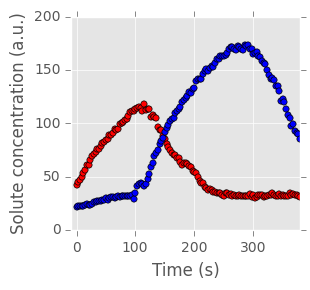

In [10]:
plt.style.use('ggplot')
#plt.figure(figsize=(3, 3))

fig = plt.figure(figsize=(3.2, 3))
ax = fig.add_subplot(111)

major_xticks = np.arange(0, 400, 100)
ax.set_xticks(major_xticks)
x = range(len(front_peak))
x_values = [item*spf for item in x]
front = plt.scatter(x_values, front_peak, color='red', edgecolor='black', label='Front peak')
back = plt.scatter(x_values, back_peak, edgecolor='black', label='Back peak')
plt.xlabel('Time (s)')
plt.ylabel('Solute concentration (a.u.)')
plt.xlim(-10, np.amax(x_values))
#ax.set_xticklabels([])
#ax.set_yticklabels([])
#plt.legend(handles=[front, back], loc='upper left');
plt.tight_layout()
plt.savefig('../results/plot_concentration_front_back.eps', dpi=600)

## Function to measure the width of the peak

found here: http://stackoverflow.com/questions/10582795/finding-the-full-width-half-maximum-of-a-peak

In [11]:
from scipy.interpolate import splrep, sproot, splev

def fwhm(x, y, k=10):
    """
    Determine full-with-half-maximum of a peaked set of points, x and y.

    Assumes that there is only one peak present in the datasset.  The function
    uses a spline interpolation of order k.
    """

    class MultiplePeaks(Exception): pass
    class NoPeaksFound(Exception): pass

    #half_max = np.amax(y)*0.5
    half_max = 9 # look at the width of the peak where the solute concentration = 10 (a.u.)
    # i.e. we want to measure the width of the peak at its base
    s = splrep(x, y - half_max)
    roots = sproot(s)

    if len(roots) > 2:
        raise MultiplePeaks("The dataset appears to have multiple peaks, and "
                "thus the FWHM can't be determined.")
    elif len(roots) < 2:
        raise NoPeaksFound("No proper peaks were found in the data set; likely "
                "the dataset is flat (e.g. all zeros).")
    else:
        return abs(roots[1] - roots[0])

## Measure the width of the front peak

In [12]:
front_width = []
for i in range(0,130,1):
    ys = data[i][40:70] # get a 20 pixel wide section
    ys = np.average(ys, axis=0) #average along the width to remove the noise
    ind = detect_peaks(ys, show=False, edge='both',mph=15, mpd=50)
    front_value = ind[0] # get the value of intensity at the position of the peak
    if ind[0]<particle_position[i]:
        Y = ys[0:particle_position[i]] # select only the first peak. stop the intensity profile at the position of the center of the particle
        X = range(0,len(Y), 1)
        width = fwhm(X,Y)
    else:
        width = 0
#    width = fwhm(X,Y)
    front_width.append(width)
    


/Users/sylvaindeville/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [13]:
x_width = range(len(front_width))

# convert from frames to seconds using the initial calibration  
x_values_width = [item*spf for item in x_width]

# Convert from pixel to microns using the initial calibration
front_width_microns = [item*mpf for item in front_width]

## Plot Fig 4D of the paper

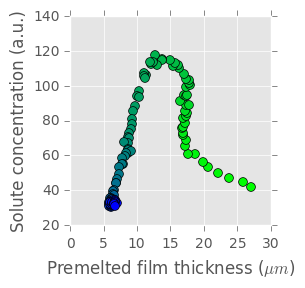

In [19]:
fig, ax1 = plt.subplots(figsize=(3, 3))
plt.xlabel(r'Premelted film thickness ($\mu m$)')
plt.ylabel('Solute concentration (a.u.)')
for i in range(0,130,1):
    color_code = (1-i/130)
    front_plot = ax1.scatter(front_width_microns[i], front_peak[i], 
                             color=(0,color_code,1-color_code), s=40, 
                             label='Solute concentration', 
                             edgecolor='black')
#plt.xlim(0,np.amax(x_values_width))
#plt.legend(handles=[front_plot, width_plot]);
#ax1.set_xticklabels([])
#ax1.set_yticklabels([])
plt.tight_layout()
plt.savefig('../results/width_plot.eps', dpi=600)

## Plot Fig 4E of the paper

In [25]:
data = pims.TiffStack('../data/DD 16.075A(1mkm-sec)_2-Series007-3.tif')
mpf = 1/2.2462 # microns per pixels

In [26]:
selection = data[0][45:50] # get a 20 pixel wide section
average_profile = np.average(selection, axis=0)

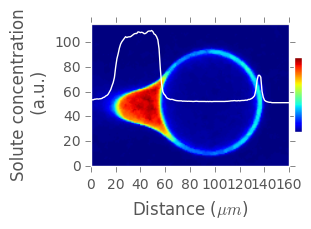

In [39]:
#data2 = pims.TiffStack('../data/DD 16.075A(1mkm-sec)_2-Series007-3.tif')

plt.style.use('ggplot')
fig, ax1 = plt.subplots(figsize=(3.5, 3))
plt.xlabel(r'Distance ($\mu m$)')
plt.ylabel('Solute concentration \n (a.u.)')
#ax1.axes.get_xaxis().set_ticklabels([])
#ax1.axes.get_yaxis().set_ticklabels([])
#ax1.set_xticks([]) 
#ax1.set_yticks([]) 
cax = plt.imshow(data[0])
plt.xlim(0,160)
plt.ylim(0,115)
ax1.grid(False)
# Add colorbar, make sure to specify tick locations to match desired ticklabels
cbar = fig.colorbar(cax, shrink=0.3,
                    aspect=10,pad=0.02, ticks=None, orientation='vertical'  )
cbar.ax.set_xticklabels('')  # vertically oriented colorbar
cbar.set_ticks([-10,300])
plt.plot(average_profile/2+50, color="white")
plt.tight_layout()
plot_filename = '../results/premelting_profile.eps'
plt.savefig(plot_filename, dpi=600)

In [40]:
#%install_ext http://raw.github.com/jrjohansson/version_information/master/version_information.py\n",
# you need to run the line above only once
%load_ext version_information
%reload_ext version_information
%version_information numpy, scipy, matplotlib, pandas, trackpy, skimage

Software versions
Python 2.7.12 64bit [GCC 4.2.1 (Based on Apple Inc. build 5658) (LLVM build 2336.11.00)]
IPython 4.2.0
OS Darwin 17.3.0 x86_64 i386 64bit
numpy 1.9.3
scipy 0.17.1
matplotlib 1.4.3
pandas 0.16.2
trackpy 0.3.1
skimage 0.11.3
Wed Jan 24 13:41:54 2018 CET